<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring Drop Spreading Law

George McNie<br>
University of Manchester  
January 2021

We first initialise our Python interpreter

In [15]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fsolve 
plt.rcParams.update({'font.size': 14})
plt.style.use('default')

![](./img/bee.png)
## Experimental Data

This is data that you are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [16]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])

#convert to SI units, so from micro meters to meters
radius_data1 *= 1e-6
radius_data2 *= 1e-6
radius_data3 *= 1e-6


# time in seconds
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Let's plot this data to see what it looks like:

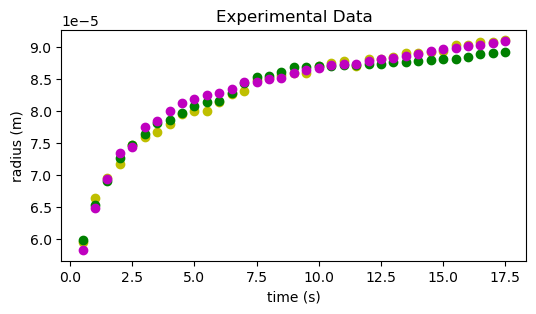

In [17]:
def plot_1(data_1, data_2, data_3):
    # tweeking the figure size
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    # plotting data from experimental runs 1-3:
    plt.plot(time, radius_data1, "yo")
    plt.plot(time, radius_data2, "go")
    plt.plot(time, radius_data3, "mo")
    # setting axis labels & figures 
    plt.xlabel("time (s)")
    plt.ylabel("radius (m)")
    plt.title("Experimental Data")
    # displaying the plot
    plt.show()
    
plot_1(radius_data1,radius_data2, radius_data3)

Don't forget to find the errors on $R$ estimated from the three experimental runs.

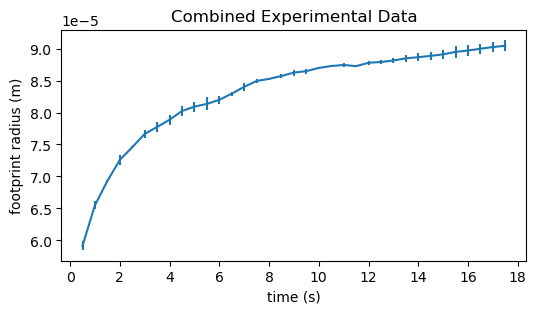

In [18]:
def mean_and_error_three_arrays(array_1, array_2, array_3):
    mean = np.mean(np.array([array_1, array_2, array_3]), axis=0)
    error = np.std(np.array([array_1, array_2, array_3]), axis=0)
    return mean, error

mean_radii, error_radii = mean_and_error_three_arrays(radius_data1, radius_data2, radius_data3)

def plot_2(mean_data, error, time):
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    # plotting data from experimental runs 1-3 combined:
    plt.errorbar(time, mean_data, error)
    plt.xticks(np.arange(0,20,2))
    # setting axis labels & figures 
    plt.xlabel("time (s)")
    plt.ylabel("footprint radius (m)")
    plt.title("Combined Experimental Data")
    # displaying the plot
    plt.show()
    
plot_2(mean_radii, error_radii, time)

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

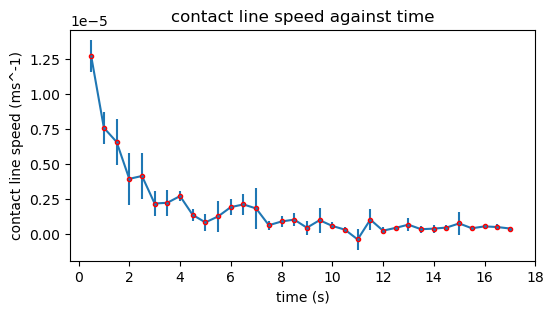

In [19]:
timestep = 0.5 #timestep between data points read is set as global variable

def get_speed(radius):
    U = np.diff(radius)/timestep #due to function workings (like said above have difference between consecutive vals) 
                                     #so length of list 1 smaller than raw data 
    return U
        
speed_1 = get_speed(radius_data1)
speed_2 = get_speed(radius_data2)
speed_3 = get_speed(radius_data3)

mean_speed, error_speed = mean_and_error_three_arrays(speed_1, speed_2, speed_3)

def plot_3(mean_data, error, time):
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    # plotting speed of drop against time:
    plt.errorbar(time[:-1], mean_data, yerr=error, marker = '.', mec='red')
    plt.xticks(np.arange(0,20,2))
    # setting axis labels & figures 
    plt.xlabel("time (s)")
    plt.ylabel("contact line speed (ms^-1)")
    plt.title("contact line speed against time")
    # displaying the plot
    plt.show()
    
plot_3(mean_speed, error_speed, time)

Let's plot these results to see what they look like:

In [20]:
V = 7.6e-18 #volume of drop in m^3 set to global variable

def height_equation(height, R):
    return (np.pi*height*(R**2))/2+(np.pi*(height**3)/6) - V #set equation linking height, radius and volume = 0

def find_height(radius_array):
    height_array = np.array([])
    for i in radius_array:
        h = fsolve(height_equation, 0, args=(i))
        height_array = np.append(height_array, h)
    return height_array



The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

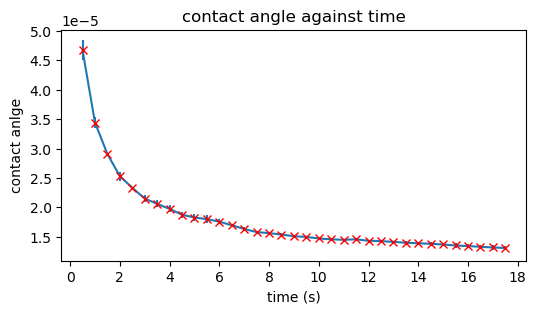

In [21]:
def contact_angle_func(radius, height):
    """
    gets contanct angle theta =pi/2 - arctan([R^2-H^2]/2RH)
    """
    theta = (np.pi/2) - np.arctan(((radius**2)-(height**2)) / (2*radius*height))
    return theta

def plot_4(angles, errors, time): # plottingcontact angle against time
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    plt.errorbar(time, angles, errors, marker = 'x', mec='red')
    plt.xticks(np.arange(0,20,2))
    # setting axis labels & figures 
    plt.xlabel("time (s)")
    plt.ylabel("contact anlge")
    plt.title("contact angle against time")
    # displaying the plot
    plt.show()

contact_angle_1 = contact_angle_func(radius_data1, find_height(radius_data1))
contact_angle_2 = contact_angle_func(radius_data2, find_height(radius_data2))
contact_angle_3 = contact_angle_func(radius_data3, find_height(radius_data3))

mean_angle, error_angle = mean_and_error_three_arrays(contact_angle_1, contact_angle_2, contact_angle_3)

plot_4(mean_angle, error_angle, time)

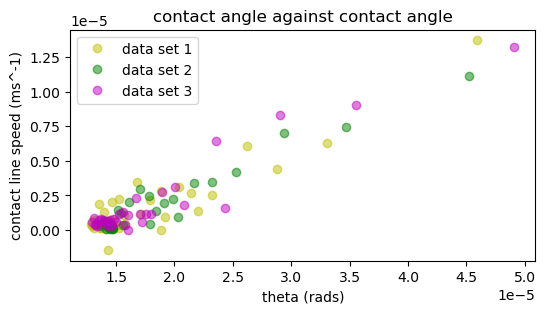

In [22]:
def plot_5(speed_1, speed_2, speed_3, angles_1, angles_2, angles_3): # plotting speed against contact angle for each data set
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    plt.plot(angles_1, speed_1, "yo", label="data set 1", alpha= 0.5) #plots data set 1's speed against it's calculated contact angles
    plt.plot(angles_2, speed_2, "go", label="data set 2", alpha= 0.5)
    plt.plot(angles_3, speed_3, "mo", label="data set 3", alpha= 0.5)
    # setting axis labels & figures 
    plt.xlabel("theta (rads)")
    plt.ylabel("contact line speed (ms^-1)")
    plt.title("contact angle against contact angle")
    plt.legend()
    # displaying the plot
    plt.show()
    
plot_5(speed_1, speed_2, speed_3, contact_angle_1[:-1], contact_angle_2[:-1], contact_angle_3[:-1])

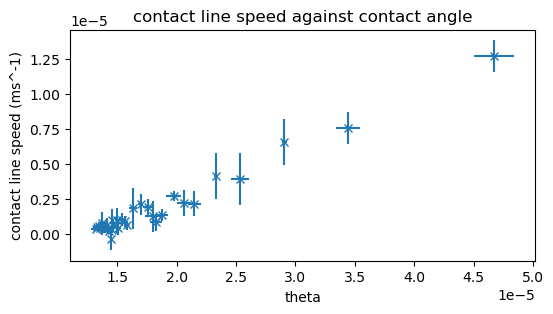

In [23]:
def plot_6(speed, angles, error_speed, error_angle): # plotting mean speed against mean contact angle
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    plt.errorbar(angles, speed, yerr=error_speed, xerr=error_angle, fmt='x')
    plt.xlabel("theta")
    plt.ylabel("contact line speed (ms^-1)")
    plt.title("contact line speed against contact angle")
    # displaying the plot
    plt.show()
    
plot_6(mean_speed, mean_angle[:-1], error_speed, error_angle[:-1])

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

Have general form of equation $U(\theta) = A X + B $ where X is $\theta^2$ for de gennes law and $\theta^3$ for Cox-Voinov law.
The errors propogated here to get $\delta U_0^{fit}$ use the standard error propogation but rearanged.

In [24]:
#use polyfit to fit line to law, U = U_0(theta^2) - U_0(theta_0^2) = U_0(theta^2) - b
theta_square = np.power(mean_angle, 2)
G_coefficients, G_covarients = np.polyfit(theta_square[:-1], mean_speed, 1, cov=True) # coefficients has array with value U_0 and -b
#covarients gives covarients matrix, top left value = (error on U_0)^2, bottom right = (error on b)^2
G_Pfit = np.polyval(G_coefficients, theta_square[:-1])
G_U_zero = G_coefficients[0]
G_b = -G_coefficients[1]
G_error_u_zero = np.sqrt(G_covarients[0,0])
G_error_b = np.sqrt(G_covarients[1,1])
G_theta_zero = np.sqrt(G_b/G_U_zero)
G_theta_zero_error = np.sqrt((G_b/(4*(G_U_zero)**3))*(G_error_u_zero)**2 + (1/(4*G_U_zero*G_b))*(G_error_b)**2)
#print(theta_zero, theta_zero_error)


#use polyfit to fit line to law, U = U_0(theta^3) - U_0(theta_0^3) = U_0(theta^3) - b
theta_cubed = np.power(mean_angle, 3)
C_coefficients, C_covarients = np.polyfit(theta_cubed[:-1], mean_speed, 1, cov=True) # coefficients has array with value U_0 and -b
#covarients gives covarients matrix, top left value = (error on U_0)^2, bottom right = (error on b)^2
C_Pfit = np.polyval(C_coefficients, theta_cubed[:-1])
C_U_zero = C_coefficients[0]
C_b = C_coefficients[1]
C_error_u_zero = np.sqrt(C_covarients[0,0])
C_error_b = np.sqrt(C_covarients[1,1])
C_theta_zero = (C_b/C_U_zero)**(1/3)
C_theta_zero_error = np.sqrt((C_b**(1/3)*(-1/3)*(1/(C_U_zero)**(-2/3)*C_error_u_zero))**2 - ((1/3*(1/(C_U_zero**(1/3)))*(1/C_b**(-1/3))*C_error_b)**2))
#print(theta_zero, theta_zero_error)

Displaying the corresponding fits  

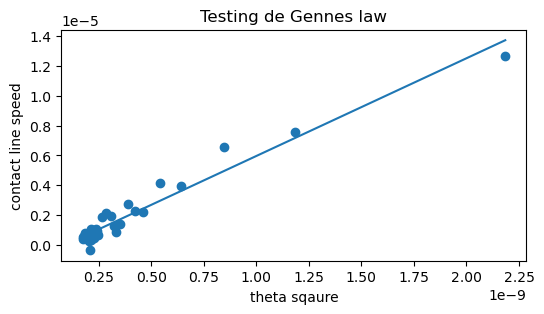

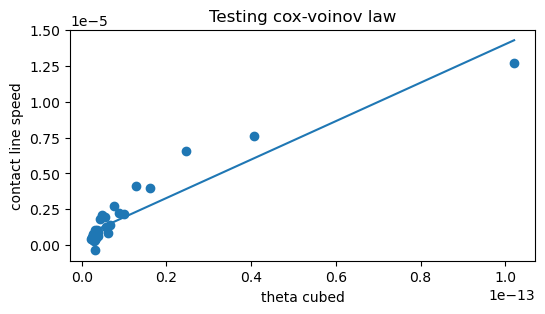

In [25]:
def plot_7(speed, angles, pfit): # plotting mean speed against mean contact angle
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    plt.scatter(angles, speed)
    plt.plot(angles, pfit)
    plt.xlabel("theta sqaure")
    plt.ylabel("contact line speed")
    plt.title("Testing de Gennes law")
    # displaying the plot
    plt.show()

def plot_8(speed, angles, pfit): # plotting mean speed against mean contact angle
    plt.rcParams["figure.figsize"] = (6,3)
    plt.figure()
    plt.scatter(angles, speed)
    plt.plot(angles, pfit)
    plt.xlabel("theta cubed")
    plt.ylabel("contact line speed")
    plt.title("Testing cox-voinov law")
    # displaying the plot
    plt.show()


plot_7(mean_speed, theta_square[:-1], G_Pfit)
plot_8(mean_speed, theta_cubed[:-1], C_Pfit)

![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. 

GENNES LAW : chi2 =  1.1 and COX-VOINOV LAW : CHI2 =  3.7 


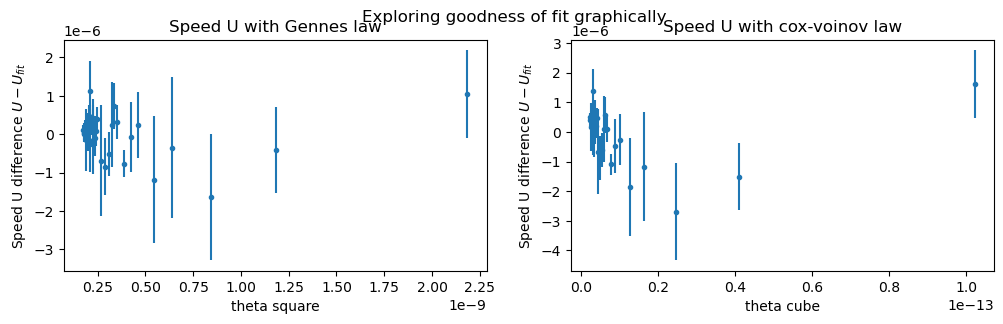

In [26]:
def get_chi_square(velocity, sigma_velocity, contact_speed_fit, n):
    return sum(((velocity-contact_speed_fit)/sigma_velocity)**2)/(np.size(velocity)-(n+1))

G_chi = get_chi_square(mean_speed, error_speed, G_Pfit, 3)
C_chi = get_chi_square(mean_speed, error_speed, C_Pfit, 3)

plt.rcParams["figure.figsize"] = (12, 3)
#plotting figs side by side
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Exploring goodness of fit graphically')

ax1.errorbar(theta_square[:-1], (G_Pfit-mean_speed), yerr= error_speed, fmt=".")
ax1.set(xlabel = "theta square")
ax1.set(ylabel = "Speed U difference $U-U_{fit}$")
ax1.set_title("Speed U with Gennes law")

ax2.errorbar(theta_cubed[:-1], (C_Pfit-mean_speed), yerr= error_speed, fmt=".")
ax2.set(xlabel = "theta cube")
ax2.set(ylabel = "Speed U difference $U-U_{fit}$")
ax2.set_title("Speed U with cox-voinov law")

print("GENNES LAW : chi2 = {0:4.1f} and COX-VOINOV LAW : CHI2 = {1:4.1f} ".format(G_chi, C_chi))

![](./img/bee.png)
## Drop Spreading Law Is

The results of the chi-squared analysis suggest that the "" law is a better fit for the behaviour of the spreading drop because ...  

In [27]:
print("De-Gennes results:")
print("\nThe characteristic speed of the contact line is ({:.4} +/- {:.4})".format(G_U_zero,G_error_u_zero))
print("The equilibrium contact angle is ({:.4} +/- {:.4})".format(G_theta_zero,G_theta_zero_error))

print("\nCox-Voinov results:")
print("\nThe characteristic speed of the contact line is ({:.4} +/- {:.4})".format(C_U_zero,C_error_u_zero))
print("The equilibrium contact angle is ({:.4} +/- {:.4})".format(C_theta_zero,C_theta_zero_error))

De-Gennes results:

The characteristic speed of the contact line is (6.567e+03 +/- 264.1)
The equilibrium contact angle is (9.62e-06 +/- 1.127e-06)

Cox-Voinov results:

The characteristic speed of the contact line is (1.343e+08 +/- 8.691e+06)
The equilibrium contact angle is (1.641e-05 +/- 6.385e+09)


THE DE GENNES LAW PROVIDES A MUCH BETTER VALUE OF CHI SQUARE THAN THE COX-VOINOV LAW SUGGESTING THE BEHAVIOUR OF THE DROP IS MUCH BETTER MODELLED USING THE DE GENNES LAW. CAN ALSO SEE ON RESIDUALS PLOTS THAT THERE IS A HIGHER CONCENTRATION OF POINTS AROUND 0 FOR THE DE-GENNES LAW.


![](./img/bee.png)
## Stretch yourself section

This section is to be populated by you entirely 